# CBOE Volatility Index (VIX)
This Jupyter Notebook is an application of the information provided in the CBOE white paper, which you can browse [here](https://www.cboe.com/micro/vix/vixwhite.pdf).
<br><br>Introduced in 1993, the VIX index was originally designed to measure the market's expectation of 30-day volatility, implied by at-the-money S&P 500 index option prices. It was updated in 2003 to better reflect expected volatility. The new VIX estimates expected volatility by aggregating the weighted prices of SPX (S&P 500) puts and calls over a wide range of strike prices. It was further expanded in 2014 to include series of SPX weeklys.
<br>The VIX is a premier benchmark for US stock market volatility, being regularly featured in US news, newspaper, cable, etc.
<br>
<br>The VIX index is tradable through futures on the CBOE Futures Exchange (CFE), i.e. volatility is a tradable asset. The goal is to diversify and hedge one's portfolio thanks to the usual negative correlation of volatility to stock market returns.
### Terms
<b>At-the-money</b>: Situation where an option's strike price (K) is identical to the price of the underlying security (S).
<br><b>Bid, ask, and bid-ask spread</b>: The bid price represents the maximum price that a buyer is willing to pay for a security. The ask price represents the minimum price that a seller is willing to receive. A bid-ask spread is the amount by which the ask price exceeds the bid price for an asset in the market.
<br><b>Out-of-the-money</b>: An out of the money option has no intrinsic value, but only possesses extrinsic or time value. Being out of the money doesn't mean a trader can't make a profit on that option.
<br><b>Weeklys</b>: Weekly options available on many indexes, equities, etc.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import requests
import xml.etree.ElementTree as ET

from scipy import interpolate

from yahoo_fin import options as op, stock_info as si
# get_expiration_dates() does not work in Jupyter Notebook
#chain = op.get_expiration_dates("^SPX")

### Example of a call option pricing using Black Scholes
To give you an example of how an option's price can be estimated, find below the modelization of a call option using the common and historic Black Scholes formula.

Value of the European call option: 8.019103.
Value of the European call option: 7.551576.


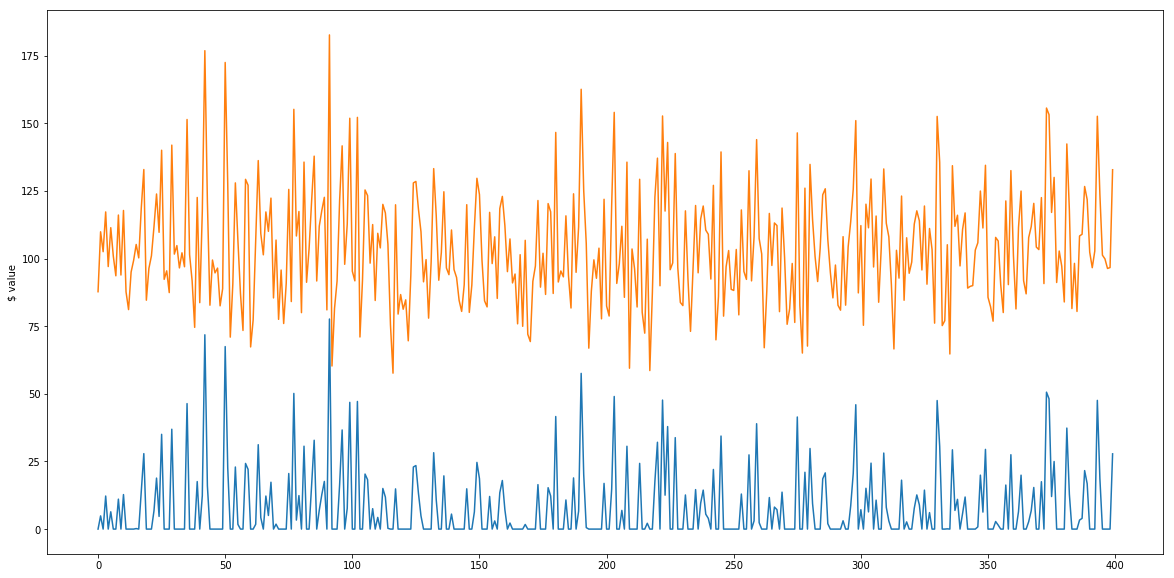

In [2]:
def black_scholes_modelization(stock_pr, strike_pr, maturity, rf_rate, stock_volat, nb_simul, graph = False):
    """
    Modelizes the Black Scholes formula of option pricing based on the common and historic formula
    :param <stock_pr>: Float ; Underlying index/stock price at valuation
    :param <strike_pr>: Float ; Strike price of option
    :param <maturity>: Float ; Time to maturity in years
    :param <rf_rate>: Float ; Risk-free rate
    :param <stock_volat>: Float ; Underlying index/stock volatility
    :param <nb_simul>: Integer ; Number of simulations
    :param <graph>: Boolean ; Boolean to show a graph or not
    """
    S0 = stock_pr
    K = strike_pr
    T = maturity
    r = rf_rate
    sigma = stock_volat
    I = nb_simul
    
    np.random.seed(1000)
    z = np.random.standard_normal(I)
    ST = S0 * np.exp((r-sigma**2/2)*T + sigma * math.sqrt(T)* z) #simulation of index/stock price at maturity
    hT = np.maximum(ST - K, 0) #pay-off at maturity
    
    C0 = math.exp(-r * T) * np.mean(hT) #Monte Carlo estimator
    print("Value of the European call option: {:5.6f}.".format(C0))
    
    if graph == True:
        plt.figure(figsize=(20,10))
        plt.plot(hT)
        plt.plot(ST)
        plt.ylabel('$ value')
        plt.show()

# EXAMPLES
black_scholes_modelization(100., 105., 1.0, 0.05, 0.2, 100000)
black_scholes_modelization(100., 105., 1.0, 0.05, 0.2, 400, True)

### The VIX Index Calculation
The generalized formula used in the FIX index calculation is:

$$\sigma^2 = \frac{2}{T}*\sum_{i}\frac{\Delta*K_i*e^{R*T}*Q(K_i)}{K_i^2}-\frac{1}{T}*[\frac{F}{K_0}-1]^2$$

where:

$VIX = \sigma * 100$

$T = \text{time to expiration}$

$F = \text{Forward index level derived from index options prices}$

$K_0 = \text{First strike below the forward index level, F}$

$K_i = \text{Strike price of } i^\text{th} \text{ out-of-the-money option; a call if } K_i > K_0 \text{ and a put if } K_i < K_0 \text{ ; both put and call if } K_i = K_0$

$\Delta*K_i = \text{Interval between strike prices - half the difference between the strike on either side of } K_i$

$$\Delta*K_i = \frac{K_{i+1} - K_{i-1}}{2}$$

$R = \text{Risk-free interest rate to expiration}$

$Q(K_i) = \text{The midpoint of the bid-ask spread for each option with strike }K_i$

### Modelling T
The VIX measures 30-day expected volatility of the S&P 500 Index. <b>The components of the VIX are near- and next-term put and call options with more than 23 days and less than 37 days to expiration</b>. These include SPX options with "standard" 3rd Friday expiration dates and "weekly" SPX options that expire every Friday, except the 3rd Friday of each month.
<br>Once each week, the SPX options used to calculate the VIX Index "roll" to new contract maturities (shortest: 24 - 30 day expirations ; latest: 30 - 37 day expirations).

$$T = \frac{M_\text{Current day} + M_\text{Settlement day} + M_\text{Other days}}{\text{Minutes in a year}}$$

where:

$M_\text{Current day} = \text{minutes remaining to midnight of the current day}$

$\text{Either: }M_\text{Settlement day} = \text{minutes from midnight until 08:30am (EST) for "standard" SPX expirations}$

$\text{Or: }M_\text{Settlement day} = \text{minutes from midnight until 04:00pm (EST) for "weekly" SPX expirations}$

$M_\text{Other days} = \text{Total minutes in the days between current day and expiration day}$

$\text{Minutes in a year} = 525600$

<b>Two T values are calculated</b>: $T_1$ for the near-term options, $T_2$ for the next-term options.

In [3]:
def time_to_expiration(term = True):
    """
    Calculates the time to expiration.
    :param <term>: boolean ; True == "Near-term", False == "Next-term"
    """
    #current time + tomorrow
    now = datetime.datetime.now()
    day = datetime.date.today()
    tomorrow = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(1)
    
    #near- or next-term
    if term == True:
        val = 0
    else:
        val = 7
    
    #calculation of minutes remaining until midnight of the current day
    minutes_to_midnight_today = int(round(abs(tomorrow - now).seconds / 60,0))
    
    #calculation of total minutes in the days between current day and expiration day
    for index in range(24,38):
        day = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
        if day.weekday() == 4:
            days_to_expiration = index + val - 1
            if day.weekday() == 4 and 15 <= day.day <= 21:
                minutes_to_settlement = 510
            else:
                minutes_to_settlement = 900
            break
    
    return (minutes_to_midnight_today + minutes_to_settlement + (days_to_expiration) * 24 * 60)/525600

### Modelling R
To go with $T_1$ and $T_2$, two risk-free interest rates are also calculated. $R_1$ and $R_2$ are yields based on the US Treasury yield curve rates, also commonly referred to as "Constant Maturity Treasury" rates or CMTs.

<b>Fitting a yield curve using cubic spline</b>:
<br>The goal is to fit a cubic polynomial to the existing yields and maturities of the US Treasury bonds, which together form the "yield curve"--it is actually a discrete list of points in a graph. The goal is to solve a cubic polynomial by minimizing the sum of squared residuals.
$$\hat{r}(t) = \beta_0 + \beta_1 * t + \beta_2 * t^2 + \beta_3 * t^3$$

In [4]:
def us_treasury_yield_curve():
    """
    Retrieves and formats the us treasury yield curve.
    No arguments.
    """
    response = requests.get("https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/XmlView.aspx?data=yield")
    root = ET.fromstring(response.content)

    temp_us_treasury_dict={}
    us_treasury_dict={}
    
    for elt in root.iter():
        temp_us_treasury_dict[elt.tag[-8:]] = elt.text
    
    for key in temp_us_treasury_dict.keys():
        if (key.find("MONTH") + key.find("YEAR") + key.find("DATE") != -3):
            us_treasury_dict[re.sub(r'.*_', '', key)] = temp_us_treasury_dict[key]
    
    return us_treasury_dict

In [5]:
def yield_curve_minute_conversion(us_treasury_yields):
    """
    Formats a series of US Treasury yields in minute to expiration
    :param <us_treasury_yields>: dictionary ; contains the list of yield curves of the US treasury bonds
    """
    # Based on the average number of day in a month: 30.42
    minutes_in_a_month = 43804
    minutes_in_a_year = 525600
    
    #minute axis
    x = []
    
    #yield axis
    y = []
    
    #yield_curve_in_minutes = {}
    for key in us_treasury_yields.keys():
        if key.find("MONTH") != -1:
            x.append(int(key[:-5])*minutes_in_a_month)
            y.append(us_treasury_yields[key])
        elif key.find("YEAR") != -1:
            x.append(int(key[:-4])*minutes_in_a_year)
            y.append(us_treasury_yields[key])
    
    return [x,y]

In [6]:
def cubic_spline_risk_free_rate_function(time_to_expiration, minute_data = False):
    """
    Estimates the risk free rate (based on the US treasury yield) at a specific time to expiration
    :param <time_to_expiration>: integer ; time to expiration in day or minutes 
    :param <minute_data>: boolean ; indicates if the argument <time_to_expiration> is in minutes or days
    """
    yield_curve = yield_curve_minute_conversion(us_treasury_yield_curve())
    x_points = yield_curve[0]
    y_points = yield_curve[1]
    tck = interpolate.splrep(x_points, y_points)
    
    if minute_data == False:
        #current time + tomorrow
        now = datetime.datetime.now()
        tomorrow = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(1) 
        
        #calculation of total minutes in the days between current day and expiration day
        for index in range(24,38):
            day = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
            if day.weekday() == 4:
                days_to_expiration = index - 1
                if day.weekday() == 4 and 15 <= day.day <= 21:
                    minutes_to_settlement = 510
                else:
                    minutes_to_settlement = 900
                break
        
        #calculation of minutes remaining until midnight of the current day
        minutes_to_midnight_today = int(round(abs(tomorrow - now).seconds / 60,0))
        time_to_expiration = (time_to_expiration-1) * 24 * 60 + minutes_to_settlement + minutes_to_midnight_today        
        
        return interpolate.splev(time_to_expiration, tck)
    
    else:
        return interpolate.splev(time_to_expiration, tck)

The estimated risk free rates at expiration date can be estimated as such:

In [7]:
dates = [time_to_expiration(True),time_to_expiration(True)]

estimated_risk_free_rate = []

for date in dates:
    estimated_risk_free_rate.append(float(cubic_spline_risk_free_rate_function(date*525600, True)))

### Selecting the options to be used in the VIX Index Calculation
The selected options are out-of-the-money SPX calls and out-of-the-money SPX puts centered around an at-the-money strike price $K_0$. Volatility rises and falls constantly. It implies that the number of options used in the VIX Index calculation may vary from month-to-month, day-to-day, and even minute-to-minute.

<b>Extracting option data and working on them</b>
<br>The goal is to find the "near-term" and "next-term" option strike prices for which, the absolute difference between the call and put prices is the smallest. Those two values will be used to compute a "forward" level, denoted $F$ such as:

$$F = \text{Strike Price} + e^{R * T} * (\text{Call Price} - \text{Put Price})$$

Settlement dates for S&P options occur every two days during the workweek (Monday, Wednesday, Friday). We are looking to extract the option data for the "Near-term" and "next-term" Fridays.
<br><br><b>Known issue of yahoo_fin in Jupyter Notebook</b>: the method "get_expiration_date()" does not work due to a Runtime error. Jupyter being an event loop, the method throws the following error: "Cannot use HTMLSession within an existing event loop. Use AsyncHTMLSession instead." To keep this notebook self-contained, we will have to rework the expiration date of each option from their name in the option chain.

In [8]:
def get_snp_price():
    """
    Returns the live price of the S&P index.
    No arguments.
    """
    return si.get_live_price("^GSPC")

In [9]:
def day_of_expiration():
    """
    Determines the date of near-term and next-term settlement Fridays.
    No arguments.
    """
    now = datetime.datetime.now()
    
    for index in range(24,38):
        day = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
        if day.weekday() == 4:
            near_term = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
            next_term = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index+7)
            break
    
    return [near_term, next_term]       

In [10]:
def option_chain_v0():
    """
    Return the out of the money SPX calls and puts last price on the market.
    [[{out of the money near-term calls last price}, {out of the money next-term calls last price}], 
    [{out of the money near-term puts last price},{out of the money next-term puts last price}]]
    No arguments.
    """
    dates = day_of_expiration()
    snp_price = get_snp_price()
    call_list = [{},{}]
    put_list = [{},{}]
    for idx1, date in enumerate(dates):
        snp_option_chain = op.get_options_chain("^SPX",str(date.strftime("%x")))
        for idx2, item in enumerate(snp_option_chain["calls"]["Strike"]):
            if item > snp_price:
                call_list[idx1][item] = snp_option_chain["calls"]["Last Price"][idx2]
                
        for idx3, item in enumerate(snp_option_chain["puts"]["Strike"]):
            if item < snp_price:
                put_list[idx1][item] = snp_option_chain["puts"]["Last Price"][idx3]
    return [call_list, put_list]

In [11]:
def option_chain():
    """
    Return the out of the money SPX calls and puts last price on the market.
    [[{out of the money near-term calls last price}, {out of the money next-term calls last price}], 
    [{out of the money near-term puts last price},{out of the money next-term puts last price}]]
    No arguments.
    """
    dates = day_of_expiration()
    snp_price = get_snp_price()
    call_list = [{},{}]
    put_list = [{},{}]
    for idx1, date in enumerate(dates):
        snp_option_chain = op.get_options_chain("^SPX",str(date.strftime("%x")))
        for idx2, item in enumerate(snp_option_chain["calls"]["Bid"]):
            if item != 0:
                call_list[idx1][snp_option_chain["calls"]["Strike"][idx2]] = snp_option_chain["calls"]["Last Price"][idx2]
                
        for idx3, item in enumerate(snp_option_chain["puts"]["Bid"]):
            if item != 0:
                put_list[idx1][snp_option_chain["puts"]["Strike"][idx3]] = snp_option_chain["puts"]["Last Price"][idx3]
    return [call_list, put_list]

In [12]:
def merge_puts_calls_dict(chain):
    """
    Merges out of the money puts and calls by last price and near- or next-term.
    :param <chain>: data structure ; list of lists of dictionaries that contains out of the money, 
        near- and next-term puts and calls last prices
    """
    
    dates = day_of_expiration()
    result = []
    chain = option_chain()
    
    for index, date in enumerate(dates):
        d = {}
        keys = []
        
        for key in set(list(chain[0][index].keys()) + list(chain[1][index].keys())):
            try:
                d.setdefault(key,[]).append(chain[index][0][key])        
            except KeyError:
                pass
            try:
                d.setdefault(key,[]).append(chain[index][1][key])          
            except KeyError:
                pass
        
        for key in d.keys():
            if len(d[key]) != 2: keys.append(key)
        
        for key in keys:
            del d[key]
        
        result.append(d)
    
    return result

In [13]:
def call_put_difference_for_single_strike_white_paper_method():
    """
    Provide the strike price and the associated difference between Call and Put prices, for which it is the smallest.
    This version uses the method explicited in the CBOE white paper.
    No arguments.
    """
    chain = merge_puts_calls_dict(option_chain())
    difference = []
    for term in range(2):
        diff = -1.
        strike= 0.
        for key in chain[term].keys():
            if (diff == -1 or diff > abs(chain[term][key][0] - chain[term][key][1])) and abs(chain[term][key][0] -
                                                                                             chain[term][key][1]) != 0:
                diff = abs(chain[term][key][0] - chain[term][key][1])
                strike = key
        difference.append([strike, diff])
    return difference

In [14]:
def find_F():
    """
    Provide the forward index prices for the near- and next-term options
    No arguments.
    """
    dates = [time_to_expiration(True),time_to_expiration(False)]
    estimate = call_put_difference_for_single_strike_white_paper_method()
    F = []
    for i in range(2):
        F.append(estimate[i][0] + math.exp(estimated_risk_free_rate[i]*dates[i]) * estimate[i][1])
    return F

<b>Determining $K_0$ from the forward index level $F$</b>:
<br>From $F$ we can determine $K_{0,1}$ and $K_{0,2}$ (near-term and next-term), the strike price immediately below the forward index level. It is rounded to the closest multiple of 5.

In [15]:
def strike_price_under_F():
    """
    Returns the strike price immediately below the forward index level F for the near-and next-term options.
    No arguments.
    """
    dates = day_of_expiration()
    F = find_F()
    K = []
    for counter, date in enumerate(dates):
        snp_option_chain = op.get_options_chain("^SPX",str(date.strftime("%x")))
        strikes = sorted(list(snp_option_chain["puts"]["Strike"])+list(snp_option_chain["calls"]["Strike"]))
        for item in range(1, len(strikes)):
            if strikes[item] > F[counter]:
                K.append(strikes[item-1])
                break
        if len(K) < counter+1: K.append(round(F[counter]-5))
    return K

In [16]:
F_values = find_F()
K = strike_price_under_F()

<b>Selection of the options to be used in the VIX index calculation:</b>
<br>Select out-of-the-money call options with strike prices > $K_{0}$. Start with the put strike immediately higher than $K_{0}$ and move to successively higher strike prices. Exclude any call option that has a bid price equal to zero (i.e. no bid). Once two calls with consecutive strike prices are found to have zero bid prices, no calls with higher strikes are considered for inclusion.
<br><br>Select out-of-the-money put options with strike prices < $K_{0}$. Start with the put strike immediately higher than $K_{0}$ and move to successively lower strike prices. Exclude any put option that has a bid price equal to zero (i.e. no bid). Once two puts with consecutive strike prices are found to have zero bid prices, no puts with lower strikes are considered for inclusion.
<br><br>We include the formula below the options value at strike price for ease of use for the next step.

We construct a table that contains the options used to calculate the VIX. We select both the put and call retrieved using the function above along with the put and call average at strike price $K_{0}$. The VIX used the average of quoted bid and ask, or mid-quote, prices for each option selection. The $K_{0}$ put and call prices are average to produce a single value.

We reproduce this method both for near- and next-term.

In [17]:
def retained_options_out_of_the_money():
    """
    Retrieves the out-of-the-money option data: strike, bid, ask
    No arguments.
    """
    dates = day_of_expiration()
    
    call_data = [[[],[],[]],[[],[],[]]]
    put_data = [[[],[],[]],[[],[],[]]]
    
    for date in range(2):
        snp_option_chain = op.get_options_chain("^SPX",str(dates[date].strftime("%x")))
        counter = 0
        for index in range(len(snp_option_chain["calls"]["Strike"])):           
            if snp_option_chain["calls"]["Strike"][index] > K[date]:
                if snp_option_chain["calls"]["Bid"][index] == 0:
                    if counter == 1:
                        break
                    else:
                        counter += 1
                else:
                    counter = 0
                    call_data[date][0].append(snp_option_chain["calls"]["Strike"][index])
                    call_data[date][1].append(snp_option_chain["calls"]["Bid"][index])
                    call_data[date][2].append(snp_option_chain["calls"]["Ask"][index])
        
        counter = 0
        for index in reversed(range(len(snp_option_chain["puts"]["Strike"]))):
            if snp_option_chain["puts"]["Strike"][index] < K[date]:
                if snp_option_chain["puts"]["Bid"][index] == 0:
                    if counter == 1:
                        break
                    else:
                        counter += 1
                else:
                    counter = 0
                    put_data[date][0].append(snp_option_chain["puts"]["Strike"][index])
                    put_data[date][1].append(snp_option_chain["puts"]["Bid"][index])
                    put_data[date][2].append(snp_option_chain["puts"]["Ask"][index])
        
    return [call_data, put_data]

In [18]:
def retained_options_at_the_money():
    """
    Retrieves the at-the-money option data: strike, bid, ask
    No arguments.
    """
    dates = day_of_expiration()
    
    call_data = [[[],[],[]],[[],[],[]]]
    put_data = [[[],[],[]],[[],[],[]]]
    
    for date in range(2):
        snp_option_chain = op.get_options_chain("^SPX",str(dates[date].strftime("%x")))
        try:
            index = list(snp_option_chain["calls"]["Strike"]).index(K[date])
            call_data[date][0] = snp_option_chain["calls"]["Strike"][index]
            call_data[date][1] = snp_option_chain["calls"]["Bid"][index]
            call_data[date][2] = snp_option_chain["calls"]["Ask"][index]
        except Exception as e:
            pass
        try:
            index = list(snp_option_chain["puts"]["Strike"]).index(K[date])
            put_data[date][0] = snp_option_chain["puts"]["Strike"][index]
            put_data[date][1] = snp_option_chain["puts"]["Bid"][index]
            put_data[date][2] = snp_option_chain["puts"]["Ask"][index]
        except Exception as e:
            pass
    
    return [call_data, put_data]

<b>Calculate volatility for both near- and next-term options:</b>
<br>We now need to apply the VIX formula to the near-term andnext-term options with time to expiration $T_{1}$ and $T_{2}$:

$$\sigma^2_{1} = \frac{2}{T_{1}}*\sum_{i}\frac{\Delta*K_i*e^{R_{1}*T_{1}}*Q(K_i)}{K_i^2}-\frac{1}{T_{1}}*[\frac{F_{1}}{K_0}-1]^2$$

$$\sigma^2_{2} = \frac{2}{T_{2}}*\sum_{i}\frac{\Delta*K_i*e^{R_{2}*T_{2}}*Q(K_i)}{K_i^2}-\frac{1}{T_{2}}*[\frac{F_{2}}{K_0}-1]^2$$
<br>The VIX index is an amalgam of the information reflected in the prices of all of the selected options. The contribution of a single option to the IX value is proportional to $\Delta*K$ and the price of that option, and inversely proportional to the square of the option's strike price.

How to determine $\Delta*K$:
<br>Generally, $\Delta*K_i$ is half the difference between the strike prices on either side of $K_i$. At the upper and lower edges of any given strip of options, $\Delta*K_i$ is simply the difference between $K_i$ and the adjacent strike price. We speak of a near-term options to the index through the following formula:

$$\frac{\Delta*K_i*e^{R_{1}*T_{1}}*Q(K_i)}{K_i^2}$$

$$\frac{\Delta*K_i*e^{R_{2}*T_{2}}*Q(K_i)}{K_i^2}$$
<br>A similar calculation is performed for each option. The resulting values for the near-term options are then summed and multiplied by $2/T_1$. Likewise, the resulting values for the next-term options are summed and multiplied by $2/T_2$.

In [19]:
def contribution_to_VIX(retained_data_ootm, retained_data_atm, rate):
    """
    Calculates the contribution to the VIX of each single option strip.
    :param <retained_data_ootm>: list ; list of lists containing the out-of-the-money option data 
        retained to calculate the VIX
    :param <retained_data_atm>: list ; list of lists containing the at-the-money option data 
        retained to calculate the VIX
    :param <rate>: float ; estimated risk free rate
    """
    contribution = [[],[]]
    dates = day_of_expiration()
    expiration = [time_to_expiration(True), time_to_expiration(False)]
    
    for date in range(2):
        
        #OUT-OF-THE-MONEY OPTIONS
        delta = {}
        snp_option_chain = op.get_options_chain("^SPX",str(dates[date].strftime("%x")))
        for index, item in enumerate(snp_option_chain["calls"]["Strike"]):
            if item > K[date]:
                if index == 0:
                    delta[item] = abs(snp_option_chain["calls"]["Strike"][index] - 
                                      snp_option_chain["calls"]["Strike"][index+1])
                elif index < len(snp_option_chain["calls"]["Strike"]) - 1:
                    delta[item] = abs(snp_option_chain["calls"]["Strike"][index-1] -
                                      snp_option_chain["calls"]["Strike"][index+1])/2
                else:
                    delta[item] = abs(snp_option_chain["calls"]["Strike"][index] - 
                                      snp_option_chain["calls"]["Strike"][index-1])
        
        for index, item in enumerate(snp_option_chain["puts"]["Strike"]):
            if item < K[date]:
                if index == 0:
                    delta[item] = abs(snp_option_chain["puts"]["Strike"][index] - 
                                      snp_option_chain["puts"]["Strike"][index+1])
                elif index < len(snp_option_chain["puts"]["Strike"]) - 1:
                    delta[item] = abs(snp_option_chain["puts"]["Strike"][index-1] -
                                      snp_option_chain["puts"]["Strike"][index+1])/2
                else:
                    delta[item] = abs(snp_option_chain["puts"]["Strike"][index] - 
                                      snp_option_chain["puts"]["Strike"][index-1])
        
        for index in range(len(retained_data_ootm[0][date][0])):
            contrib = (2/expiration[date])*delta[retained_data_ootm[0][date][0][index]]/(K[date]**2)*\
                        math.exp(rate[date]/100*expiration[date])*\
                        abs(retained_data_ootm[0][date][1][index]-retained_data_ootm[0][date][2][index])
            contribution[date].append(contrib)
        for index in range(len(retained_data_ootm[1][date][0])):
            contrib = (2/expiration[date])*delta[retained_data_ootm[1][date][0][index]]/(K[date]**2)*\
                        math.exp(rate[date]/100*expiration[date])*\
                        abs(retained_data_ootm[1][date][1][index]-retained_data_ootm[1][date][2][index])
            contribution[date].append(contrib)
    
        #AT-THE-MONEY OPTIONS
        if isinstance(retained_data_atm[0][date][0],np.float64) == False:
            if isinstance(retained_data_atm[1][date][0],np.float64):
                contrib = (2/expiration[date])*abs(delta[retained_data_ootm[1][date][0][index]])/(K[date]**2)*\
                        math.exp(rate[date]/100*expiration[date])*\
                        abs(retained_data_atm[1][date][1]-retained_data_atm[1][date][2])
                contribution[date].append(contrib)
        else:
            if isinstance(retained_data_atm[1][date][0],np.float64) == False:
                contrib = (2/expiration[date])*abs(delta[retained_data_ootm[1][date][0][index]])/(K[date]**2)*\
                        math.exp(rate[date]/100*expiration[date])*\
                        abs(retained_data_atm[0][date][1]-retained_data_atm[0][date][2])
                contribution[date].append(contrib)
            else:
                contrib = (2/expiration[date])*abs(delta[retained_data_ootm[1][date][0][index]])/(K[date]**2)*\
                        math.exp(rate[date]/100*expiration[date])*\
                        (abs(retained_data_atm[0][date][1]-retained_data_atm[0][date][2])+\
                         abs(retained_data_atm[1][date][1]-retained_data_atm[1][date][2]))/2
                contribution[date].append(contrib)
    return contribution

In [20]:
rates = estimated_risk_free_rate
retained_options_ootm = retained_options_out_of_the_money()
retained_options_atm = retained_options_at_the_money()

near_term_sum_of_contribution = sum(contribution_to_VIX(retained_options_ootm, retained_options_atm, rates)[0])
next_term_sum_of_contribution = sum(contribution_to_VIX(retained_options_ootm, retained_options_atm, rates)[1])

Next we calculate:
$$\frac{1}{T_{1}}*[\frac{F_{1}}{K_0}-1]^2$$
and
$$\frac{1}{T_{2}}*[\frac{F_{2}}{K_0}-1]^2$$

In [21]:
expiration = [time_to_expiration(True), time_to_expiration(False)]

near_term_time_component = 1 / expiration[0] * (F_values[0] / K[0] - 1)**2
next_term_time_component = 1 / expiration[1] * (F_values[1] / K[1] - 1)**2

Now we can calculate $\sigma^2_{1}$ and $\sigma^2_{2}$:

In [22]:
near_term_sigma_squared = near_term_sum_of_contribution - near_term_time_component
next_term_sigma_squared = next_term_sum_of_contribution - next_term_time_component

### Calculate the VIX
We calculate the 30-day weighted average of $\sigma^2_{1}$ and $\sigma^2_{2}$, then take the square root of the value and multiply by 100 to get the VIX value:

$$VIX = 100 * \sqrt{(T_1 * \sigma^2_{1}*\frac{N_{T_2}-N_{30}}{N_{T_2}-N_{T_1}} + T_1 * \sigma^2_{2}*\frac{N_{30}-N_{T_1}}{N_{T_2}-N_{T_1}}) * \frac{N_{365}}{N_{30}}}$$
<br> where:

$N_{T_1}$ = number of minutes to settlement of the near-term options

$N_{T_2}$ = number of minutes to settlement of the next-term options

$N_{30}$ = number of minutes in 30 days (i.e. 43,200)

$N_{365}$ = number of minutes in a 365-day year (i.e. 525,600)

In [23]:
near_term_minutes = time_to_expiration(True) * 525600
next_term_minutes = time_to_expiration(False) * 525600
month_minutes = 43200
year_minutes = 525600

In [24]:
VIX = round(100 * math.sqrt((time_to_expiration(True) * near_term_sigma_squared * 
                      ((next_term_minutes - month_minutes)/(next_term_minutes - near_term_minutes)) + 
                     time_to_expiration(False) * next_term_sigma_squared * 
                      ((month_minutes - near_term_minutes)/(next_term_minutes - near_term_minutes))) * 
                     (year_minutes / month_minutes)),2)
print(f"The VIX index is estimated at: {VIX}.")

The VIX index is estimated at: 6.6.


## Conclusion
As at June 7th, 2019, the calculated VIX is of <b>6.6</b>, compared to a market-provided 16.3.

The discrepancy can be explained by the incompleteness of the data available through the Yahoo finance module. It does not provide always puts and calls with the same strike price. This makes hard to calculate an actual VIX as the first step of the calculation (determining the forward SPX level F for the near- and next-term expirations) requires calls and puts of similar strike price.
This forces us to exclude otherwise valuable option data, which renders the calculation incomplete. The approximation remains nonetheless valuable for understanding how the index is built.